I am currently checking out a clustering algorithm: [DBSCAN](https://en.wikipedia.org/wiki/DBSCAN) (Density-Based Spatial Clustering of Application with Noise). As the name suggested, it is a density based clustering algorithm: given a set of points in some space, it groups together points that are closely packed together (points with many nearby neighbors), and marks points as outliers if they lie alone in low-density regions. It has many advantages, including no need specify the number of clusters, can find arbitrary shaped clusters, relatively fast, etc. Of course, there's no single algorithm can do everything, DBSCAN has disadvantage as well.   

The algorithm has two parameters: epsilon and min_points, the advantage of the algorithm is that you don’t have to specify how many clusters you need, it can find all the clusters that satisfy the requirement. For the disadvantage, it is very sensitive to the parameter you choose. 

The summary of this algorithm is:  
**Step 1:** For each point in the dataset, we draw a n-dimensional sphere of radius epsilon around the point (if you have n-dimensional data).  
**Step 2:** If the number of points inside the sphere is larger than min_points, we set the center of the sphere as a cluster, and all the points within the sphere are belong to this cluster.  
**Step 3:** Loop through all the points within the sphere with the above 2 steps, and expand the cluster whenever it satisfy the 2 rules.   
**Step 4:** For the points not belong to any cluster, you can ignore them, or treat them as outliers.  

The original paper about DBSCAN was published 10 years ago in 1996, and can be found [here](https://www.aaai.org/Papers/KDD/1996/KDD96-037.pdf). It is ranked the [41st place](http://academic.research.microsoft.com/RankList?entitytype=1&topDomainID=2&subDomainID=7&last=0&start=1&end=100) in the most cited publication in data mining. If you find the paper is too heavy on defining different points, you can check this very nice video on youtube shows how this works: [Here](
https://www.youtube.com/watch?v=5E097ZLE9Sg). Scikit learn already has a very nice example to show the effectiveness of the algorithm. You can find the example [here](http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html)

![sklearn example](http://scikit-learn.org/stable/_images/plot_cluster_comparison_001.png)

## Grab the earthquake data

In [103]:
%matplotlib inline  
import pandas as pd
import numpy as np
import folium
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

Earthquake data can be get from the [ANSS catalog](http://www.ncedc.org/anss/catalog-search.html). For simplicity, I just download aftershock data above Magnitude 2.0 for one week after the [Loma Prieta earthquake](https://en.wikipedia.org/wiki/1989_Loma_Prieta_earthquake). All together, there are 1009 earthquakes in this region. 

In [102]:
# Read in earthquake data
df = pd.read_csv('./LomaPrieta_aftershocks_1week_above_2.csv', skiprows = 7)

# Get the latitude and logitude of the earthquakes
coords = df.as_matrix(columns=['Latitude', 'Longitude'])

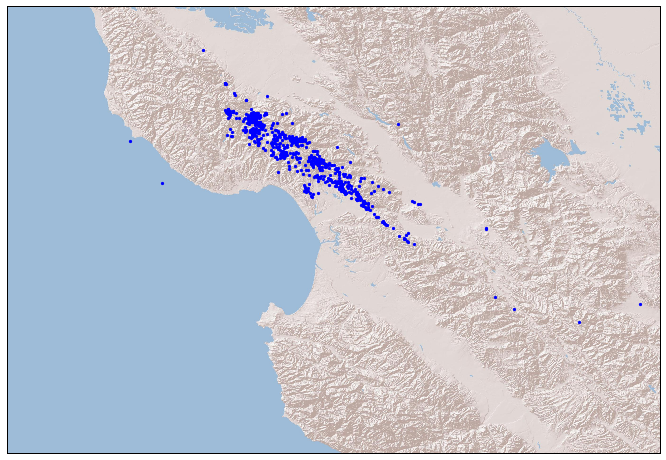

In [106]:
# Plot the location of the earthquakes

plt.figure(figsize = (12, 8))

m = Basemap(projection='merc', resolution='l', epsg = 4269, 
            llcrnrlon=-122.7,llcrnrlat=36.2, urcrnrlon=-120.8,urcrnrlat=37.5)

x, y = m(coords[:, 1], coords[:, 0])
m.scatter(x,y,5,marker='o',color='b')
# xpixels controls the pixels in x direction, and if you leave ypixels
# None, it will choose ypixels based on the aspect ratio
m.arcgisimage(service='World_Shaded_Relief', xpixels = 5000, verbose= False)
    
plt.show()
